In [87]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import utils
import json
import warnings
warnings.filterwarnings("ignore")

In [88]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [89]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION_1 = STATION.replace(" ", "_")

In [90]:
project = hopsworks.login()
fs = project.get_feature_store() 
# secrets = utils.secrets_api(project.name)

"""
city_secrets = json.loads(secrets.get_secret("city_secrets").value)
CITY = city_secrets["city"]
latitude = city_secrets["latitude"]
longitude = city_secrets["longitude"]

time_secrets = json.loads(secrets.get_secret("time_secrets").value)
earliest_bike_datetime = time_secrets["earliest_bike_datetime"]
last_bike_datetime = time_secrets["last_bike_datetime"]
"""

CITY = "dublin"
# latitude =
# longitude =

earliest_bike_datetime = "2023-08-05 12:56:53 UTC"
last_bike_datetime = "2025-01-06 15:06:11 UTC"

today = datetime.now()

print(type(fs))

2025-01-08 11:21:41,481 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 11:21:41,490 INFO: Initializing external client
2025-01-08 11:21:41,491 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 11:21:42,874 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494
<class 'hsfs.feature_store.FeatureStore'>


## Creating the feature view

In [91]:
# Retrieve feature groups
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

In [92]:
selected_features = bike_fg.select(["num_bikes_available", "station"]).join(weather_fg.select_all(), on=['datetime'])

# selected_features.show(1056438)
selected_features.show(10)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.81s) 


,num_bikes_available,station,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,9.0,HEUSTON_BRIDGE_(NORTH),2023-08-07 07:00:00+00:00,12.589500,10.889786,0.0,0.0,12.538134,55149.910156,0.1,dublin
1,5.0,HEUSTON_BRIDGE_(NORTH),2023-08-07 13:00:00+00:00,16.039499,14.021429,0.0,0.0,15.629971,55149.910156,0.1,dublin
2,3.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 09:00:00+00:00,15.889501,15.685719,0.0,0.0,5.634891,54933.734375,0.1,dublin
3,3.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 15:00:00+00:00,17.789499,17.170294,0.0,0.0,7.289445,54933.734375,0.1,dublin
4,40.0,HEUSTON_BRIDGE_(NORTH),2023-08-08 21:00:00+00:00,16.189499,16.359585,0.0,0.0,4.072935,54933.734375,0.1,dublin
5,0.0,HEUSTON_BRIDGE_(NORTH),2023-08-09 13:00:00+00:00,22.289499,23.308016,0.0,0.0,11.885453,54714.667969,0.0,dublin
6,24.0,HEUSTON_BRIDGE_(NORTH),2023-08-11 18:00:00+00:00,18.489500,15.696390,0.0,0.0,24.954519,54268.824219,0.4,dublin
7,32.0,HEUSTON_BRIDGE_(NORTH),2023-08-11 22:00:00+00:00,16.239500,13.714560,0.0,0.0,24.400459,54268.824219,0.4,dublin
8,33.0,HEUSTON_BRIDGE_(NORTH),2023-08-12 19:00:00+00:00,17.589499,15.664591,0.0,0.0,18.775303,54042.503906,6.3,dublin
9,37.0,HEUSTON_BRIDGE_(NORTH),2023-08-12 20:00:00+00:00,16.539499,14.640366,0.0,0.0,18.374111,54042.503906,6.3,dublin


In [93]:
feature_view = fs.get_or_create_feature_view(
    name='bike_weather_fw',
    description="weather features with bike availability as the target",
    version=1,
    labels=['num_bikes_available'],
    query=selected_features,    
)

In [94]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.35s) 


In [95]:
# Remove rows with NaN/NaT values from X_train and X_test
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Save for later
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

In [96]:
# Adjust y_train and y_test to match the cleaned X_train and X_test
y_train = y_train.loc[X_train_raw.index]
y_test = y_test.loc[X_test_raw.index]

# Ensure the datetime column is in datetime format
X_train['datetime'] = pd.to_datetime(X_train_raw['datetime'], errors='ignore')
X_test['datetime'] = pd.to_datetime(X_test_raw['datetime'], errors='ignore')

# Extract 'month' and 'weekday' from datetime
X_train['month'] = X_train['datetime'].dt.month
X_train['weekday'] = X_train['datetime'].dt.weekday  # 0=Monday, 6=Sunday
X_train['hour'] = X_train['datetime'].dt.hour
X_train = X_train.drop(columns=['datetime', "city", "station"])

X_test['month'] = X_test['datetime'].dt.month
X_test['weekday'] = X_test['datetime'].dt.weekday
X_test['hour'] = X_test['datetime'].dt.hour
X_test = X_test.drop(columns=['datetime', "city", "station"])

In [97]:
X_train

,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,month,weekday,hour
1,16.039499,14.021429,0.0,0.00,15.629971,55149.910156,0.100000,8,0,13
2,15.889501,15.685719,0.0,0.00,5.634891,54933.734375,0.100000,8,1,9
3,17.789499,17.170294,0.0,0.00,7.289445,54933.734375,0.100000,8,1,15
5,22.289499,23.308016,0.0,0.00,11.885453,54714.667969,0.000000,8,2,13
6,18.489500,15.696390,0.0,0.00,24.954519,54268.824219,0.400000,8,4,18
...,...,...,...,...,...,...,...,...,...,...
9254,6.589500,2.101312,2.5,0.00,23.222788,27450.589844,9.000001,1,2,2
9255,5.289500,1.706616,0.0,0.00,13.934604,27450.589844,9.000001,1,2,16
9256,-1.160500,-4.447107,0.0,0.00,5.829888,27530.275391,0.000000,1,3,20
9257,2.939500,-0.981389,0.0,0.00,12.841963,27616.025391,0.000000,1,4,14


In [98]:
y_test

,num_bikes_available
0,9.0
4,40.0
14,38.0
27,37.0
39,26.0
...,...
9228,35.0
9235,36.0
9251,26.0
9258,26.0


## Training the model!

In [99]:
# Creating two instances of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [100]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 13.422624
R squared: 0.9239535324172694


In [101]:
df_station = y_test.copy()
df_station['predicted_num_bikes_available'] = y_pred

In [102]:
df_station

,num_bikes_available,predicted_num_bikes_available
0,9.0,7.442132
4,40.0,35.509342
14,38.0,37.760365
27,37.0,35.864082
39,26.0,33.064377
...,...,...
9228,35.0,30.990257
9235,36.0,36.221333
9251,26.0,26.034872
9258,26.0,26.270193


In [103]:
X_test_raw

,station,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,HEUSTON_BRIDGE_(NORTH),2023-08-07 07:00:00+00:00,12.589500,10.889786,0.0,0.00,12.538134,55149.910156,0.100000,dublin
4,HEUSTON_BRIDGE_(NORTH),2023-08-08 21:00:00+00:00,16.189499,16.359585,0.0,0.00,4.072935,54933.734375,0.100000,dublin
14,HEUSTON_BRIDGE_(NORTH),2023-08-16 03:00:00+00:00,11.689500,11.502944,0.0,0.00,3.075841,53119.523438,1.200000,dublin
27,HEUSTON_BRIDGE_(NORTH),2023-08-25 23:00:00+00:00,12.039500,10.645134,0.0,0.00,10.948973,50991.179688,3.200000,dublin
39,HEUSTON_BRIDGE_(NORTH),2023-09-03 18:00:00+00:00,20.739500,21.603697,0.0,0.00,6.151683,48802.816406,0.000000,dublin
...,...,...,...,...,...,...,...,...,...,...
9228,HEUSTON_BRIDGE_(NORTH),2024-12-13 20:00:00+00:00,3.089500,-0.038957,0.0,0.00,9.796366,27223.962891,0.100000,dublin
9235,HEUSTON_BRIDGE_(NORTH),2024-12-20 20:00:00+00:00,6.289500,2.429191,0.0,0.00,18.398781,27006.861328,0.600000,dublin
9251,HEUSTON_BRIDGE_(NORTH),2024-12-29 17:00:00+00:00,8.989500,4.850064,0.0,0.00,22.939232,27249.105469,0.000000,dublin
9258,HEUSTON_BRIDGE_(NORTH),2025-01-04 00:00:00+00:00,-0.060500,-3.807297,0.0,0.00,9.693296,27707.722656,3.700000,dublin


In [104]:
df_station['datetime'] = X_test_raw['datetime']
df_station_1 = df_station.sort_values(by=["datetime"])
df_station_1.head(5)

,num_bikes_available,predicted_num_bikes_available,datetime
5795,10.0,10.113011,2023-08-07 04:00:00+00:00
0,9.0,7.442132,2023-08-07 07:00:00+00:00
5797,7.0,6.979229,2023-08-07 11:00:00+00:00
4027,2.0,2.246416,2023-08-08 05:00:00+00:00
6939,0.0,0.168853,2023-08-08 10:00:00+00:00


In [105]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "bike_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [21]:
# THIS DOES NOT WORK BECAUSE WE DON'T USE A SPECIFIC TIME FOR TESTING.
# 
# Instead, we use random data in order to get a better spread in the evaluation, 
# as the model might perform different during different times of year

"""
file_path = images_dir + "/bikes_hindcast"
plt_1 = utils.plot_bike_availability_forecast(CITY, STATION_1, df_station_1, file_path + "_1.png", hindcast=True) 
plt_2 = utils.plot_bike_availability_forecast(CITY, STATION_2, df_station_2, file_path + "_2.png", hindcast=True)
plt_1.show()
plt_2.show()
"""

'\nfile_path = images_dir + "/bikes_hindcast"\nplt_1 = utils.plot_bike_availability_forecast(CITY, STATION_1, df_station_1, file_path + "_1.png", hindcast=True) \nplt_2 = utils.plot_bike_availability_forecast(CITY, STATION_2, df_station_2, file_path + "_2.png", hindcast=True)\nplt_1.show()\nplt_2.show()\n'

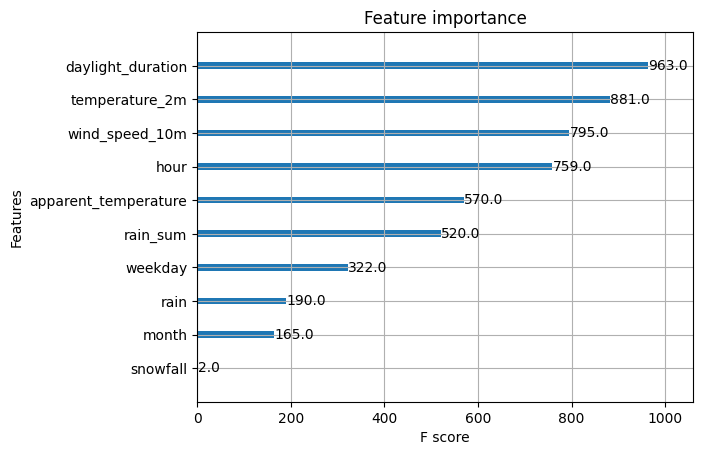

In [106]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

## Model Schema

In [107]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [108]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [109]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [110]:
mr = project.get_model_registry()

bike_availability_model = mr.python.create_model(
    name="bike_availability_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Bike availability prediction for " + STATION_1 + " in " + CITY + " using XGBoost",
)

bike_availability_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/584003 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26692 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/138 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/973 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207494/models/bike_availability_xgboost_model/1


Model(name: 'bike_availability_xgboost_model', version: 1)